In [32]:
import pandas as pd
import numpy as np

import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import seaborn as sns

In [33]:
df = pd.read_csv('peta_500.csv')  

# Clustering
### K-Means : 5 centroids

In [34]:
kmeans = cluster.KMeans(n_clusters=5, init='k-means++')
kmeans = kmeans.fit(df[['Subjectivity', 'Polarity']])

In [35]:
kmeans.cluster_centers_

array([[ 0.44482184,  0.16292359],
       [ 0.55445405, -0.37464146],
       [ 0.71424964,  0.50029221],
       [ 0.0232035 , -0.006718  ],
       [ 0.92492063, -0.75595238]])

In [36]:
df['Clusters'] = kmeans.labels_
# df.head(10)

In [37]:
df['Clusters'].value_counts()

3    184
0    173
1     95
2     33
4     15
Name: Clusters, dtype: int64

<AxesSubplot:xlabel='Subjectivity', ylabel='Polarity'>

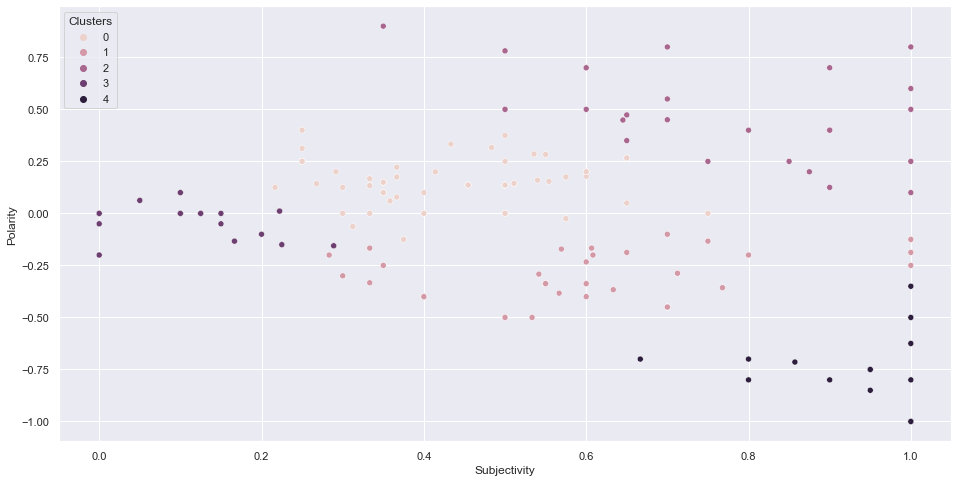

In [38]:
sns.set(rc={"figure.figsize":(16, 8)})
sns.scatterplot(x='Subjectivity', y='Polarity', hue='Clusters', data=df)

### KNN Classifier using the 5 identified clusters

In [39]:
subjectivity = df.iloc[:, 1].values
polarity = df.iloc[:, 2].values

X = list(zip(subjectivity, polarity))
X = np.array(X)
y = df.iloc[:, 4].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [40]:
def plot_decision_boundary2D(clf, X: np.ndarray, y: np.ndarray, classes: list, colormap: np.ndarray,
                             step: float = 0.1, prob_dot_scale: int = 40, prob_dot_scale_power: int = 3,
                             true_dot_size: int = 50, pad: float = 1.0,
                             prob_values: list = [0.4, 0.6, 0.8, 1.0], k = None) -> None:

    # Handling X data dimension issues. If X doesn't have enough dimensions, throw error. Too many, use first two dimensions.
    X_dim = X.shape[1]
    if X_dim < 2:
        raise Exception("Error: Not enough dimensions in input data. Data must be at least 2-dimensional.")
    elif X_dim > 2: 
        warnings.warn(f"Warning: input data was {X_dim} dimensional. Expected 2. Using first 2 dimensions provided.")
    
    # Change colormap to a numpy array if it isn't already (necessary to prevent scalar error)
    if not isinstance(colormap, np.ndarray):
        colormap = np.array(colormap)        
        
    # create the x0, x1 feature. This is only a 2D plot after all. 
    x0 = X[:,0]
    x1 = X[:,1]
    
    # create 1D arrays representing the range of probability data points
    x0_min, x0_max = np.round(x0.min())-pad, np.round(x0.max()+pad)
    x1_min, x1_max = np.round(x1.min())-pad, np.round(x1.max()+pad)    
    x0_axis_range = np.arange(x0_min,x0_max, step)
    x1_axis_range = np.arange(x1_min,x1_max, step)
    
    # create meshgrid between the two axis ranges
    xx0, xx1 = np.meshgrid(x0_axis_range, x1_axis_range)
    
    # put the xx in the same dimensional format as the original X
    xx = np.reshape(np.stack((xx0.ravel(),xx1.ravel()),axis=1),(-1,2))
    
    yy_hat = clf.predict(xx) # prediction of all the little dots
    yy_prob = clf.predict_proba(xx) # probability of each dot being 
                                    # the predicted color
    yy_size = np.max(yy_prob, axis=1)
    
    # make figure
    plt.style.use('seaborn-whitegrid') # set style because it looks nice
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), dpi=150)
    
    # plot all the little dots
    ax.scatter(xx[:,0], xx[:,1], c=colormap[yy_hat], alpha=0.4, s=prob_dot_scale*yy_size**prob_dot_scale_power, linewidths=0,)
    
    # plot the contours
    ax.contour(x0_axis_range, x1_axis_range, 
               np.reshape(yy_hat,(xx0.shape[0],-1)), 
               levels=3, linewidths=.5, 
               colors=[colormap[0],colormap[1], colormap[1], colormap[2],])
 
    # plot the original x values.
    ax.scatter(x0, x1, c=colormap[y], s=true_dot_size, zorder=3, linewidths=0.5, edgecolor='k')
 
    # create legends - Not sure if these serve a purpose but I left them in just in case
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
 
    ax.set_ylabel("Polarity")
    ax.set_xlabel("Subjectivity")
    
    # set the aspect ratio to 1, for looks
    ax.set_aspect(.4)
 
    # create class legend
    legend_class = []
    for class_id, color in zip(classes, colormap):
        legend_class.append(Line2D([0], [0], marker='o', label=class_id,ls='None',
                                   markerfacecolor=color, markersize=np.sqrt(true_dot_size), 
                                   markeredgecolor='k', markeredgewidth=0.5))
 
    # iterate over each of the probabilities to create prob legend
    legend_prob = []
    for prob in prob_values:
        legend_prob.append(Line2D([0], [0], marker='o', label=prob, ls='None', alpha=0.8,
                                  markerfacecolor='grey', 
                                  markersize=np.sqrt(prob_dot_scale*prob**prob_dot_scale_power), 
                                  markeredgecolor='k', markeredgewidth=0))
 
#     legend1 = ax.legend(handles=legend_class, loc='center', 
#                         bbox_to_anchor=(1.2, 0.25),
# #                         frameon=False
#                        )
 
#     legend2 = ax.legend(handles=legend_prob, loc='center', 
#                         bbox_to_anchor=(1.2, 0.75),
#                         frameon=False, title='prob', )
 
#     ax.add_artist(legend1) # add legend back after it disappears
 
    ax.set_yticks(np.arange(x1_min,x1_max, 1)) # I don't like the decimals
#     ax.grid(False) # remove gridlines (inherited from 'seaborn-whitegrid' style)
 
    # only use integers for axis tick labels
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
 
    # remove first ticks from axis labels, for looks
    ax.set_xticks(ax.get_xticks()[1:-1])
    ax.set_yticks(np.arange(x1_min,x1_max, 1)[1:])
    
    plt.title('Sentiment Analysis | KNN Classifier on 5 clusters'.format(k))
    plt.show()

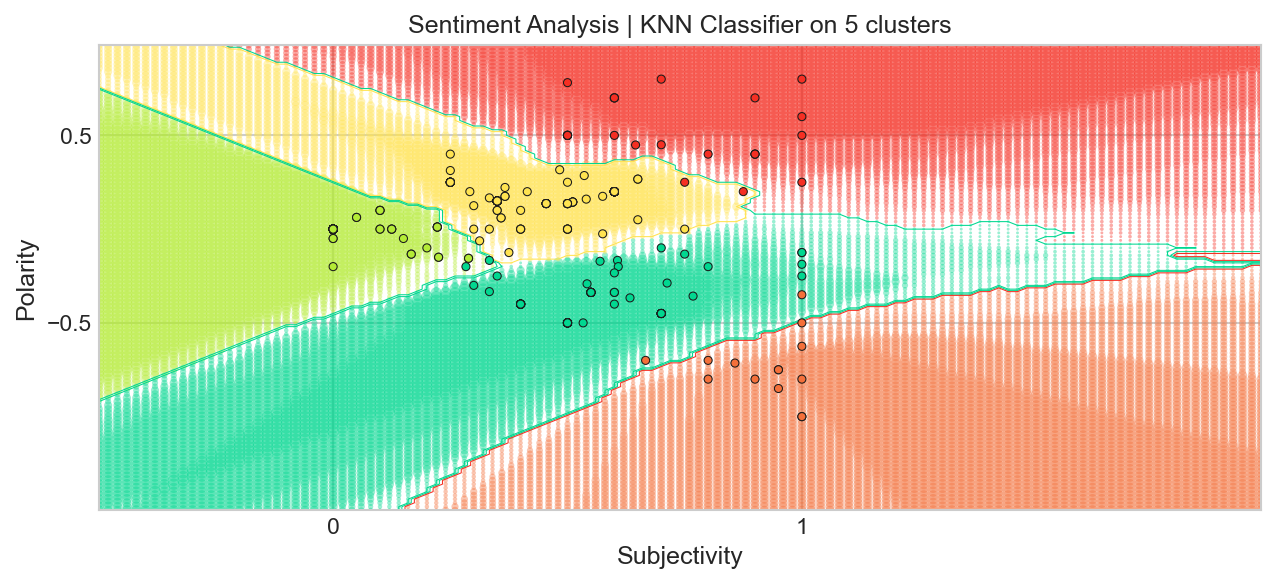

In [47]:
# set main parameters for KNN plot
N_NEIGHBORS = 15 # KNN number of neighbors
H = 0.02 # mesh stepsize
PROB_DOT_SCALE = 30 # modifier to scale the probability dots
PROB_DOT_SCALE_POWER = 3 # exponential used to increase/decrease size of prob dots
TRUE_DOT_SIZE = 15 # size of the true labels
PAD = .5 # how much to "pad" around the true labelsF5A200

# establish colors and colormap
palette = ['#FFE350', '#01D790', '#F52F23', '#B4EB36', '#F4703A']
colormap = np.array(palette)

#establish classes
classes = ['Neutral','Very Positive','Very Negative', 'Positive', 'Negative']

knn = neighbors.KNeighborsClassifier(N_NEIGHBORS, weights='uniform')
knn.fit(X_train, y_train)

# use function
plot_decision_boundary2D(knn, X_train, y_train.copy(), classes, colormap, 
                         step=H, 
                         prob_dot_scale=PROB_DOT_SCALE, 
                         prob_dot_scale_power=PROB_DOT_SCALE_POWER,
                         true_dot_size=TRUE_DOT_SIZE, 
                         pad=PAD,k=N_NEIGHBORS)

## Performance Indicators

In [48]:
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [49]:
y_pred = knn.predict(X_test)

In [50]:
print('True: ' + str(y_test[0:30]))
print('Pred: ' + str(y_pred[0:30]))
print('\nPrecision Score:\n' + str(precision_score(y_test, y_pred, average='weighted')) + '\n')
print('Recall Score:\n' + str(metrics.recall_score(y_test, y_pred, average='weighted')))

True: [0 2 0 3 0 3 1 1 1 0 0 1 0 0 1 0 0 3 3 3 0 0 3 4 1 1 0 3 3 3]
Pred: [0 2 0 3 0 3 1 1 1 0 0 1 0 0 1 0 0 3 3 3 0 0 3 4 1 1 0 3 3 3]

Precision Score:
0.9690259740259739

Recall Score:
0.97


## Confusion Matrix

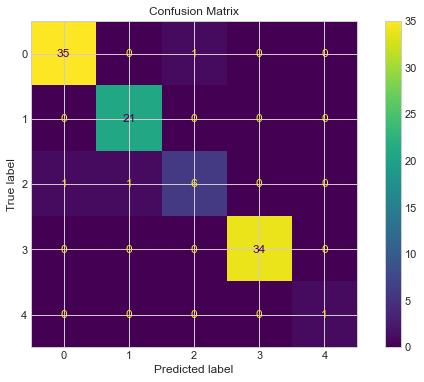

In [51]:
matrix = plot_confusion_matrix(knn, X_test, y_test)
matrix.ax_.set_title('Confusion Matrix')
plt.gcf().set_size_inches(10, 6)

# print(metrics.confusion_matrix(y_test, y_pred))